# 保険詐欺検出モデル

In [1]:
# ---------------------------------------
# ライブラリのインポート（重複除去済み）
# ---------------------------------------

# ▶ 基本操作・可視化
import pandas as pd                    # データ操作
import numpy as np                     # 数値計算
import matplotlib.pyplot as plt        # グラフ描画
import shap                            # 特徴量の可視化
import warnings                        # 警告制御
warnings.filterwarnings('ignore')      # 警告非表示

# ▶ 前処理
from sklearn.preprocessing import LabelEncoder        # ラベルエンコード
from sklearn.preprocessing import OneHotEncoder       # ワンホットエンコード
from sklearn.impute import SimpleImputer              # 欠損値補完
from sklearn.utils.class_weight import compute_sample_weight  # クラス重み
from sklearn.model_selection import train_test_split  # データ分割

# ▶ モデル
from sklearn.tree import DecisionTreeClassifier       # 決定木
from sklearn.ensemble import RandomForestClassifier   # ランダムフォレスト
from xgboost import XGBClassifier                     # XGBoost
import xgboost as xgb                                 # XGBoost本体

# ▶ 評価指標
from sklearn.metrics import (
    classification_report, confusion_matrix, auc,
    f1_score, roc_auc_score, average_precision_score,
    accuracy_score, roc_curve, precision_recall_curve
)

# ▶ 不均衡データ対策
from imblearn.over_sampling import SMOTE              # オーバーサンプリング


C:\Users\okada\anaconda3\envs\fraud-detect\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 目的と背景
保険請求データに潜む不正を検知することで、保険金の過剰支払いやリスクの増大を防ぎ、企業のコスト削減と信頼性の向上を目的をとする。本プロジェクトでは、機械学習を用いて詐欺的な請求を特定するモデルを構築します。

## 2. データの確認・前処理
本章では、機械学習モデルの構築に先立ち、欠損値の確認・カテゴリ変数のエンコーディング・不要カラムの削除など、データの前処理を実施した。これにより、モデル学習に適した形式への整形を行った。

In [2]:
# CSVファイルを読み込み
df = pd.read_csv(r'C:\Users\okada\fraud_oracle.csv')

# データセットの先頭5行を表示して内容を確認
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [3]:
# 各列に欠損値（null値）がいくつあるかを集計して表示
print(df.isnull().sum())

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
dtype: int64


In [4]:
# 'FraudFound_P'列に含まれる値（0と1）の出現回数を集計して確認
df['FraudFound_P'].value_counts()

FraudFound_P
0    14497
1      923
Name: count, dtype: int64

In [5]:
# 各列のデータ型（int, float, objectなど）を確認
df.dtypes

Month                   object
WeekOfMonth              int64
DayOfWeek               object
Make                    object
AccidentArea            object
DayOfWeekClaimed        object
MonthClaimed            object
WeekOfMonthClaimed       int64
Sex                     object
MaritalStatus           object
Age                      int64
Fault                   object
PolicyType              object
VehicleCategory         object
VehiclePrice            object
FraudFound_P             int64
PolicyNumber             int64
RepNumber                int64
Deductible               int64
DriverRating             int64
Days_Policy_Accident    object
Days_Policy_Claim       object
PastNumberOfClaims      object
AgeOfVehicle            object
AgeOfPolicyHolder       object
PoliceReportFiled       object
WitnessPresent          object
AgentType               object
NumberOfSuppliments     object
AddressChange_Claim     object
NumberOfCars            object
Year                     int64
BasePoli

In [6]:
# 目的変数を除く、データ型が'object'の列の抽出 
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# カテゴリ変数の列名リストの表示  
print("List of categorical columns:")
print(categorical_cols)

List of categorical columns:
['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed', 'MonthClaimed', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory', 'VehiclePrice', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'BasePolicy']


In [7]:
# 不必要な列の削除  
df = df.drop(['PolicyNumber', 'RepNumber'], axis=1)

# 'WeekOfMonth'と'WeekOfMonthClaimed'のカテゴリ変数リストへの追加処理
for col in ['WeekOfMonth', 'WeekOfMonthClaimed']:
    if col not in categorical_cols:
        categorical_cols.append(col)

# カテゴリ変数の文字列型への変換
df[categorical_cols] = df[categorical_cols].astype(str)

# OneHotEncoderの初期化処理
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# カテゴリ変数に対するエンコード処理
encoded_array = ohe.fit_transform(df[categorical_cols])

# エンコード後の特徴量名の取得
encoded_cols = ohe.get_feature_names_out(categorical_cols)

# エンコード結果のDataFrame化処理
encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=df.index)

# 元のカテゴリ変数の削除とエンコード結果の結合処理
df_for_model = df.drop(columns=categorical_cols)
df_for_model = pd.concat([df_for_model, encoded_df], axis=1)

# 処理結果の確認用出力
df_for_model.head()

,Age,FraudFound_P,Deductible,DriverRating,Year,Month_Apr,Month_Aug,Month_Dec,Month_Feb,Month_Jan,...,WeekOfMonth_1,WeekOfMonth_2,WeekOfMonth_3,WeekOfMonth_4,WeekOfMonth_5,WeekOfMonthClaimed_1,WeekOfMonthClaimed_2,WeekOfMonthClaimed_3,WeekOfMonthClaimed_4,WeekOfMonthClaimed_5
0,21,0,300,1,1994,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,34,0,400,4,1994,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,47,0,400,3,1994,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,65,0,400,2,1994,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,27,0,400,1,1994,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


## 3. ベースライン
本章では、詐欺検出に対する初期的なモデリングとして、決定木・ランダムフォレスト・XGBoostの3つの分類アルゴリズムを用いてベースラインモデルを構築し、モデル間の性能を比較した。特に、クラス不均衡が顕著な本データセットに対しては、各モデルにおいて重み調整を行うことでバランスを補正し、より実用的な精度評価を行った。

### 3.1 単純な決定木
まず最もシンプルな分類モデルである決定木を用いて、ベースラインとなる分類精度を確認した。クラス不均衡への対応としてclass_weight='balanced'を設定し、マイナークラス（詐欺案件）の影響も考慮したモデル構築を行った。

In [8]:
# 特徴量と目的変数への分割処理
X = df_for_model.drop('FraudFound_P', axis=1)
y = df_for_model['FraudFound_P']

# 訓練データとテストデータへの分割処理
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# クラス不均衡に対応したサンプル重みの算出処理
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# 決定木分類器の初期化処理 
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)

# サンプル重みを用いたモデルの学習処理
dt_model.fit(X_train, y_train, sample_weight=sample_weights)

DecisionTreeClassifier(max_depth=5, random_state=42)

### 3.2 ランダムフォレスト
決定木の精度と安定性を向上させるため、アンサンブル学習手法であるランダムフォレストを用いた。多数の決定木を組み合わせることで過学習を抑制しつつ、クラス不均衡への対応としてclass_weight='balanced'を使用した。

In [9]:
# クラス不均衡に対応したランダムフォレスト分類器の初期化  
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# ランダムフォレストによるモデルの学習処理  
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

### 3.3 XGBoost
より高精度な予測を目指して、勾配ブースティング手法であるXGBoostを適用した。クラス不均衡への対応としてscale_pos_weightを調整し、デフォルトのしきい値（0.5）で評価を行った。

In [10]:
# クラス不均衡比率の計算処理
negative = sum(y_train == 0)
positive = sum(y_train == 1)
scale = negative / positive

# クラス不均衡に対応したXGBoostモデルの学習処理
xgb_model = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    scale_pos_weight=scale,  # クラス不均衡に対する重みの設定
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

### 3.4 モデル比較（評価指標＋グラフ）
決定木、ランダムフォレスト、XGBoostそれぞれの分類性能を比較するため、数値評価と可視化を通じて包括的に分析した。特に不均衡データで重要な再現率やF1スコアに注目し、最適なモデルの選定に活用した。

In [11]:
# 評価対象となる学習済みモデルの辞書オブジェクト
models = {
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
}

# 評価指標の記録用リストオブジェクト
results = []

for name, model in models.items():
    # 予測確率および予測ラベルの取得処理
    y_probs = model.predict_proba(X_test)[:, 1]  # クラス1の予測確率 
    y_preds = model.predict(X_test)              # クラスラベルの予測結果

    # 各種評価指標の計算処理
    roc_auc = roc_auc_score(y_test, y_probs)
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall, precision)
    f1 = f1_score(y_test, y_preds)
    acc = accuracy_score(y_test, y_preds)

    # 評価結果の保存処理
    results.append({
        "Model": name,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc,
        "F1-score": f1,
        "Accuracy": acc,
    })

# 評価結果をデータフレーム形式に変換する処理
df_results = pd.DataFrame(results)
print(df_results)

           Model   ROC AUC    PR AUC  F1-score  Accuracy
0  Decision Tree  0.822782  0.229275  0.239445  0.608625
1  Random Forest  0.823494  0.285177  0.020101  0.936770
2        XGBoost  0.848002  0.281659  0.282686  0.736706


モデル比較の結果、ROC AUCおよびF1-scoreの観点で最も良好な結果を示したのはXGBoostであった。しかし、全体的にF1-scoreは低く、どのモデルも不正検知の精度には改善の余地があることが分かる。一方で、Accuracyが最も高かったランダムフォレストは、F1-scoreが極端に低く、クラス不均衡に強く影響されていることが示唆された。

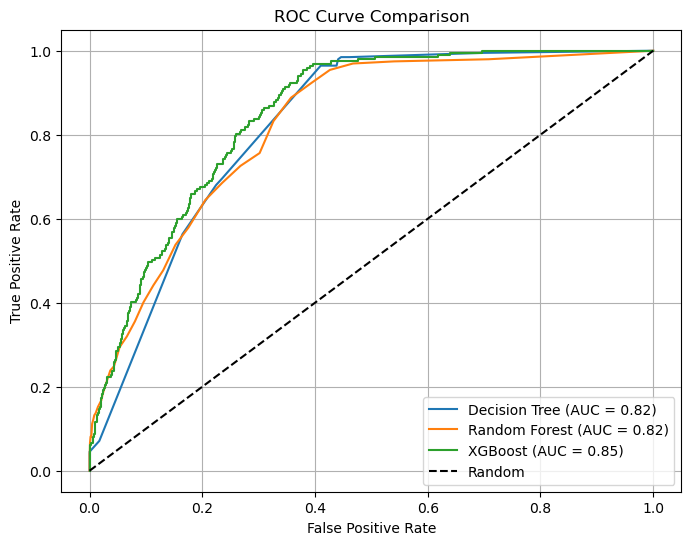

In [12]:
# プロットのサイズ設定
plt.figure(figsize=(8,6))

# 各モデルに対するROC曲線の描画処理
for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:, 1]  # クラス1の予測確率
    fpr, tpr, _ = roc_curve(y_test, y_probs)     # 偽陽性率と真陽性率の取得処理
    roc_auc = roc_auc_score(y_test, y_probs)     # AUCスコアの算出処理
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")  # モデルごとの曲線描画

# ランダム分類器の基準線描画
plt.plot([0,1], [0,1], 'k--', label='Random')

# 軸ラベルの設定処理
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")

# 凡例とグリッドの表示処理
plt.legend()
plt.grid(True)

# グラフの描画表示処理
plt.show()

ROC曲線の比較では、XGBoostが最も高いAUC（0.85）を記録し、全体的に優れた識別性能を示した。一方、決定木およびランダムフォレストはAUCが0.82と同等であったが、XGBoostに比べるとわずかに性能が劣る結果となった。

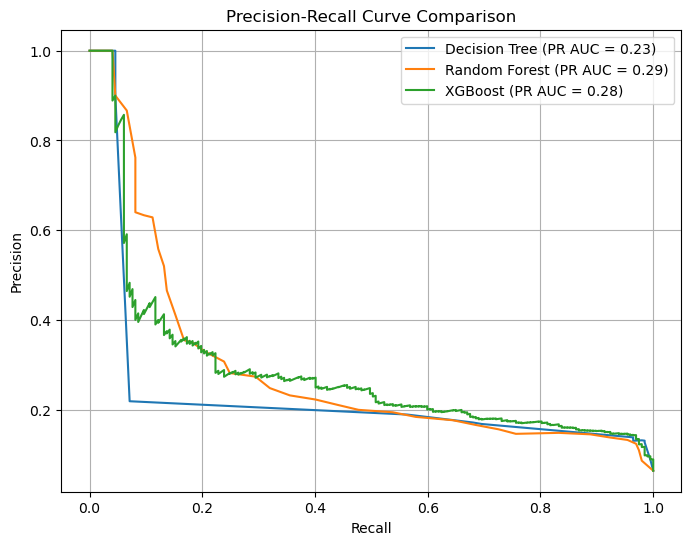

In [13]:
# プロットのサイズ設定
plt.figure(figsize=(8,6))

# 各モデルに対するPR曲線の描画処理
for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:, 1]  # クラス1の予測確率
    precision, recall, _ = precision_recall_curve(y_test, y_probs)  # 適合率と再現率の取得処理
    pr_auc = auc(recall, precision)  # PR AUCスコアの算出処理
    plt.plot(recall, precision, label=f"{name} (PR AUC = {pr_auc:.2f})")  # モデルごとの曲線描画

# 軸ラベルの設定処理
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")

# 凡例とグリッドの表示処理
plt.legend()
plt.grid(True)

# グラフの描画表示処理
plt.show()

PR曲線の比較では、Random Forestが最も高いPR AUC（0.29）を記録し、わずかにXGBoost（0.28）を上回った。一方で、Decision Treeは0.23と最も低く、再現率が高まるほど適合率が急激に低下する傾向が見られた。

## 4. 精度改善アプローチ
本章では、ベースラインモデルで得られた評価指標をさらに向上させるためのアプローチを検討した。具体的には、派生変数の追加、オーバーサンプリング（SMOTE）の適用、しきい値の最適化という3つの手法を検討・実装し、それぞれの効果をXGBoostモデルを用いて比較した。

### 4.1 派生変数の追加
本節では、既存の変数をもとに新たな特徴量を生成し、モデルに追加した。これにより、元のデータでは捉えきれなかった潜在的な関係性を補完し、モデルの識別性能を向上させることを試みた。

In [14]:
# 元データのコピーによる特徴量用データ作成処理
df_features = df_for_model.copy()

# 1. 事故日と請求日の差分日数の算出処理
# カテゴリ変数 'Days_Policy_Accident' と 'Days_Policy_Claim' を数値に変換する関数定義
def days_to_num(x):
    mapping = {
        'none': 0,
        '1 to 7': 4,
        '8 to 15': 12,
        '15 to 30': 22,
        'more than 30': 45
    }
    return mapping.get(x, -1)  # 未知の値には -1 を割り当てる処理

# 数値変換後の新しい列の追加処理
df['Days_Policy_Accident_Num'] = df['Days_Policy_Accident'].map(days_to_num)
df['Days_Policy_Claim_Num'] = df['Days_Policy_Claim'].map(days_to_num)

# 請求日と事故日の差分日数の新規特徴量作成処理
df_features['Days_Diff'] = df['Days_Policy_Claim_Num'] - df['Days_Policy_Accident_Num']

# 2. 若年ドライバーかどうかの判定処理（25歳未満なら1）
df_features['Is_YoungDriver'] = (df['Age'] < 25).astype(int)

# 特徴量と目的変数への分割処理
X = df_features.drop('FraudFound_P', axis=1)
y = df_features['FraudFound_P']

# トレーニングデータとテストデータへの分割処理
from sklearn.model_selection import train_test_split
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoostモデルの定義と学習処理（クラス不均衡に対応）
xgb_fe_model = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    scale_pos_weight=scale,  # クラス不均衡への重み補正処理
    random_state=42,
    eval_metric='logloss'
)
xgb_fe_model.fit(X_train_fe, y_train_fe) # モデルの学習処理

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

### 4.2 オーバーサンプリング
クラス不均衡の影響を緩和するため、SMOTEを用いて少数クラスのサンプルを合成し、学習データをバランス化した。これにより、過学習を抑えつつ、モデルの再現率の向上を目指した。

In [15]:
# 説明変数と目的変数への分割処理
X = df_for_model.drop('FraudFound_P', axis=1)
y = df_for_model['FraudFound_P']

# トレーニングデータとテストデータへの分割処理
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE によるオーバーサンプリング処理（マイノリティクラスの合成データ生成処理）
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# XGBoost モデルの学習処理（クラス重みは SMOTE により不要）
xgb_model_smote = XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    eval_metric='logloss'
)
xgb_model_smote.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

### 4.3 閾値調整の導入
多くの分類モデルは0.5を閾値として採用するが、これは必ずしも最適ではない。本節では、業務ニーズや評価指標に応じて柔軟に閾値を設定し、モデルの実用性向上のためのアプローチを検討した。

In [16]:
# 1. モデル定義と学習処理
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# 2. 予測確率の取得処理（クラス1に属する確率）
y_probs = xgb_model.predict_proba(X_test)[:, 1]

# 3. 複数のしきい値に対する F1 スコアの算出処理
thresholds = np.arange(0.0, 1.01, 0.01)  # 0.00〜1.00 を 0.01 刻みで生成
f1_scores = []

for t in thresholds:
    y_pred_thresh = (y_probs >= t).astype(int)  # 指定閾値による予測結果
    f1 = f1_score(y_test, y_pred_thresh)        # F1 スコアの計算処理
    f1_scores.append(f1)                        # スコアの保存処理

# 4. 最も高い F1 スコアを出す閾値の取得処理
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best threshold for F1-score:", best_threshold)

# 5. 閾値を持つカスタムモデルクラスの定義処理
class XGBWithThreshold:
    def __init__(self, model, threshold):
        self.model = model
        self.threshold = threshold

    def predict_proba(self, X):  # 確率予測メソッド
        return self.model.predict_proba(X)

    def predict(self, X):  # カスタム閾値での予測メソッド
        probs = self.model.predict_proba(X)[:, 1]
        return (probs >= self.threshold).astype(int)

# 6. 最適な閾値を持つモデルの保存処理
xgb_model_threshold = XGBWithThreshold(xgb_model, best_threshold)

Best threshold for F1-score: 0.05


### 4.4 モデル比較
本節では、ベースラインモデルおよび各改善アプローチを適用したXGBoostモデルを比較し、ROC AUC・PR AUC・F1-score・Accuracyの観点から総合的な評価を行った。

In [17]:
# モデルと名前のリスト
models = [
    ("XGBoost", xgb_model, X_test),                         # ベースラインモデル
    ("XGBoost_FE", xgb_fe_model, X_test_fe),                # 派生特徴量を加えたモデル
    ("XGBoost_SMOTE", xgb_model_smote, X_test),             # SMOTE適用済みモデル
    ("XGBoost_Threshold", xgb_model_threshold, X_test)      # 閾値調整モデル
]

# 評価結果の格納用リスト
results = []

for name, model, X_eval in models:
    # 確率予測の取得処理（閾値調整モデルは predict をオーバーライド済）
    y_pred_proba = model.predict_proba(X_eval)[:, 1]
    y_pred = model.predict(X_eval)

    # 各種評価指標の計算処理
    roc_auc = roc_auc_score(y_test, y_pred_proba)                 # ROC AUCスコア
    pr_auc = average_precision_score(y_test, y_pred_proba)        # PR AUCスコア
    f1 = f1_score(y_test, y_pred)                                 # F1スコア
    acc = accuracy_score(y_test, y_pred)                          # 正解率（Accuracy）

    # 結果の追加処理
    results.append({
        "Model": name,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc,
        "F1-score": f1,
        "Accuracy": acc
    })

# 結果をDataFrame形式で出力処理
results_df = pd.DataFrame(results)
print(results_df)

               Model   ROC AUC    PR AUC  F1-score  Accuracy
0            XGBoost  0.860446  0.289875  0.142857  0.937743
1         XGBoost_FE  0.852922  0.304544  0.273196  0.725681
2      XGBoost_SMOTE  0.847737  0.293285  0.068627  0.938392
3  XGBoost_Threshold  0.860446  0.289875  0.319742  0.794423


各精度改善手法の効果を比較した結果、ROC AUCやPR AUCに大きな変動は見られなかったものの、F1スコアにおいては閾値調整モデル（XGBoost_Threshold）が最も高い値を示した。一方で、SMOTE適用モデルはF1スコアが低下し、再サンプリングの効果には慎重な評価が求められる。

## 5. 考察
本章では、モデルの振る舞いや課題の要因を深く掘り下げるために、SHAPによる特徴量の重要度可視化と、モデル性能の伸び悩みの要因分析を行った。

### 5.1 SHAPによる特徴量重要度の可視化
モデルに対する各特徴量の影響度を可視化するため、SHAP値を用いた特徴量の重要度分析を実施した。

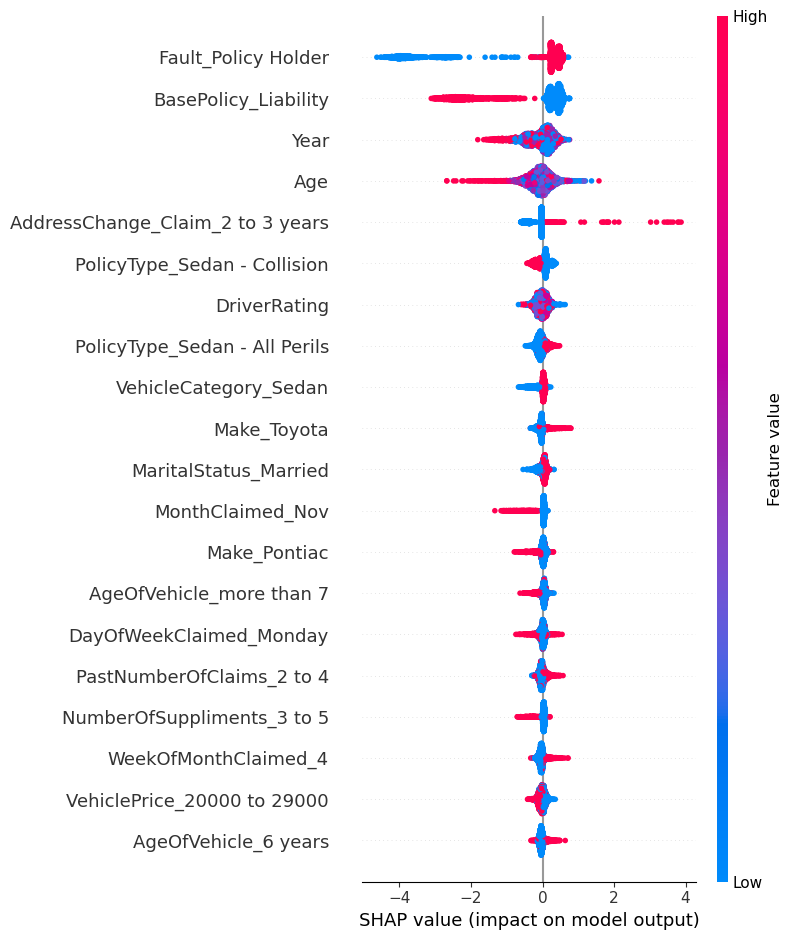

In [18]:
# SHAP値計算用の説明器（XGBoostなどの決定木系モデル用）
explainer = shap.TreeExplainer(xgb_model_threshold.model)

# SHAP値の計算
shap_values = explainer.shap_values(X_test)

# サマリープロットの表示（グローバルな特徴量重要度）
shap.summary_plot(shap_values, X_test)

### 5.2 モデル精度の伸び悩み原因考察

モデル性能の伸び悩みの一因として、まずクラス不均衡の影響が挙げられる。詐欺件数は全体のごく一部にとどまり、その結果、モデルは非詐欺クラスに偏った予測を行いやすく、F1スコアの向上に限界が見られた。この課題に対処するためにSMOTEやしきい値の調整などを試みたが、PR AUCの改善は限定的であった。これは、データ中の詐欺パターンが多様で一貫性に欠けることや、ラベル付けの曖昧さ、さらには特徴量自体の情報量不足が影響していると考えられる。加えて、ターゲット変数（詐欺）の定義そのものが現実的に難しく、モデル学習におけるノイズ源となっている可能性もある。

## 6. 結論・ビジネス的示唆

本分析では、XGBoostを中心とした複数の機械学習手法を用いて保険詐欺の検出モデルを構築し、精度・再現率・PR AUCといった評価指標に基づいて比較・検証を行った。特徴量エンジニアリングやSMOTE、しきい値調整など複数のアプローチを導入した結果、PR AUCおよびROC AUCには大きな変化は見られなかったものの、F1スコアにおいてはXGBoost_Thresholdモデルが0.14から0.32へと大幅に向上し、最も高い性能を記録した。これは、閾値調整によって非詐欺クラスに偏った予測傾向が是正され、詐欺クラスの検出能力が改善されたことを示唆している。一方で、クラス不均衡や詐欺パターンの多様性といった根本的課題は依然としてモデル精度向上の制約となっている。

ビジネス的な側面としては、完全な自動化を目指すのではなく、モデルをファーストフィルターとして活用し、人間の判断を補完する形での運用が現実的かつ有効であると考えられる。また、今後はより多様なデータソース（位置情報、通話履歴、外部データ連携など）を組み合わせることで、より実用的な不正検出の仕組みを構築できる可能性がある。